## Accuracy and training time analysis for Big Data - comparison of the simple gradient method, the stochastic gradient method and the reduction of the training set.

<center><img src='pictures/comparison.png' width=700 height=500 /></center>

## Goals:

* implementation of algorithms like Gradient Descent (GD) and Stochastic Gradient Descent (SGD) methods,
* using the first algorithm also to investigate the *undersampling* issue,
* conducting a comparative analysis of the performance of the implementation due to execution time and accuracy.

### Reaserch problem:

The **Gradient Descent** (also Steepest Descent method) boils down to the concept of a first-order iterative optimization algorithm for finding a local minimum of a differentiable function. In simple terms, the main idea of the algorithm is to repeat the steps in the direction opposite to the gradient (or approximate gradient) of the function at the current point, because this is the direction of the so-called the fastest decrease, as a result of which the sought extreme of the function will be iteratively approximated.

The algorithm, or versions that are its closer or further development, are now widely used in machine learning (ML) research. Among the solutions developed in the last decade, those versions stood out whose construction was associated with the additional use of stochastic methods.

Referring to this issue, in the undertaken study the basic algorithm was compared with two selected versions modified in terms of efficiency and precision: one additionally implementing stochastic sampling, the other using *undersampling*.

## Reaserch process:

### Used software and hardware:
* MacOs 10.15 Catalina,
* środowisko: Jupyter Notebook,
* procesor: 2,7 GHz Dwurdzeniowy procesor Intel Core i5,
* pamięć: 8 GB 1867 MHz DDR3.

### Basic information about the dataset used:

**Relevant Information**:  
   This dataset is based on "**Bank Marketing**" UCI dataset (please check the description at: http://archive.ics.uci.edu/ml/datasets/Bank+Marketing).  
   The data is enriched by the addition of five new social and economic features/attributes (national wide indicators from a ~10M population country), published by the Banco de Portugal and publicly available at: https://www.bportugal.pt/estatisticasweb.  
   This dataset is almost identical to the one used in [Moro et al., 2014] (it does not include all attributes due to privacy concerns).  
   Using the rminer package and R tool (http://cran.r-project.org/web/packages/rminer/), we found that the addition of the five new social and economic attributes (made available here) lead to substantial improvement in the prediction of a success, even when the duration of the call is not included. Note: the file can be read in R using: d=read.table("bank-additional-full.csv",header=TRUE,sep=";")  
   
   The zip file includes two datasets: 
      1) bank-additional-full.csv with all examples, ordered by date (from May 2008 to November 2010).
      2) bank-additional.csv with 10% of the examples (4119), randomly selected from bank-additional-full.csv.
   The smallest dataset is provided to test more computationally demanding machine learning algorithms (e.g., SVM).

   The binary classification goal is to predict if the client will subscribe a bank term deposit (variable y).

**Number of Instances**: 41188 for bank-additional-full.csv

**Number of Attributes**: 20 + output attribute.

**Attribute information**:

   For more information, read [Moro et al., 2014].

   **Input variables**:
   #### bank client data:
   1 - age (numeric)  
   2 - job : type of job (categorical: "admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown")  
   3 - marital : marital status (categorical: "divorced","married","single","unknown"; note: "divorced" means divorced or widowed)  
   4 - education (categorical: "basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown")  
   5 - default: has credit in default? (categorical: "no","yes","unknown")  
   6 - housing: has housing loan? (categorical: "no","yes","unknown")  
   7 - loan: has personal loan? (categorical: "no","yes","unknown")  
   #### related with the last contact of the current campaign:
   8 - contact: contact communication type (categorical: "cellular","telephone")   
   9 - month: last contact month of year (categorical: "jan", "feb", "mar", ..., "nov", "dec")  
  10 - day_of_week: last contact day of the week (categorical: "mon","tue","wed","thu","fri")  
  11 - duration: last contact duration, in seconds (numeric). Important note:  this attribute highly affects the output target (e.g., if duration=0 then y="no"). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.  
   #### other attributes:
  12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)  
  13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)  
  14 - previous: number of contacts performed before this campaign and for this client (numeric)  
  15 - poutcome: outcome of the previous marketing campaign (categorical: "failure","nonexistent","success")  
   #### social and economic context attributes
  16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)  
  17 - cons.price.idx: consumer price index - monthly indicator (numeric)  
  18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)  
  19 - euribor3m: euribor 3 month rate - daily indicator (numeric)  
  20 - nr.employed: number of employees - quarterly indicator (numeric)  

  Output variable (desired target):
  21 - y - has the client subscribed a term deposit? (binary: "yes","no")  

In [84]:
import math
import numpy as np
import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn import preprocessing

In [85]:
import warnings
warnings.filterwarnings('ignore')

plt.style.use('seaborn')
WEIGHT, HEIGHT = 7, 10

pd.set_option('display.max_columns', 22)

In [86]:
bank_marketing_df = pd.read_csv('data/bank-additional-full.csv', index_col=False, sep=';')

In [87]:
print( 'Dataset shape:', bank_marketing_df.shape )

Dataset shape: (41188, 21)


In [88]:
bank_marketing_df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
5,45,services,married,basic.9y,unknown,no,no,telephone,may,mon,198,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
6,59,admin.,married,professional.course,no,no,no,telephone,may,mon,139,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
7,41,blue-collar,married,unknown,unknown,no,no,telephone,may,mon,217,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
8,24,technician,single,professional.course,no,yes,no,telephone,may,mon,380,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
9,25,services,single,high.school,no,yes,no,telephone,may,mon,50,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no


### Basic analysis and cleaning:

In [89]:
bank_marketing_df.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

In [90]:
print( 'Number of duplicates:', len(bank_marketing_df)-len(bank_marketing_df.drop_duplicates()) )

Number of duplicates: 12


In [91]:
bank_marketing_df.drop_duplicates( inplace=True )
bank_marketing_df.reset_index()

,index,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,261,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
1,1,57,services,married,high.school,unknown,no,no,telephone,may,mon,149,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
2,2,37,services,married,high.school,no,yes,no,telephone,may,mon,226,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
3,3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,151,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
4,4,56,services,married,high.school,no,no,yes,telephone,may,mon,307,1,999,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,no
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41171,41183,73,retired,married,professional.course,no,yes,no,cellular,nov,fri,334,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes
41172,41184,46,blue-collar,married,professional.course,no,no,no,cellular,nov,fri,383,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41173,41185,56,retired,married,university.degree,no,yes,no,cellular,nov,fri,189,2,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,no
41174,41186,44,technician,married,professional.course,no,no,no,cellular,nov,fri,442,1,999,0,nonexistent,-1.1,94.767,-50.8,1.028,4963.6,yes


In [92]:
bank_marketing_df['job'].replace(["admin.","blue-collar","entrepreneur","housemaid","management","retired","self-employed","services","student","technician","unemployed","unknown"],
                                    range(bank_marketing_df['job'].unique().shape[0]), inplace=True)
bank_marketing_df['marital'].replace(["divorced","married","single","unknown"], 
                                     range(4), inplace=True)
bank_marketing_df['education'].replace(["basic.4y","basic.6y","basic.9y","high.school","illiterate","professional.course","university.degree","unknown"], 
                                       range(bank_marketing_df['education'].unique().shape[0]), inplace=True)
bank_marketing_df['default'].replace(["no","yes","unknown"], range(3), inplace=True)
bank_marketing_df['housing'].replace(["no","yes","unknown"], range(3), inplace=True)
bank_marketing_df['loan'].replace(["no","yes","unknown"], range(3), inplace=True)
bank_marketing_df['contact'].replace(["cellular","telephone"], range(2), inplace=True)
bank_marketing_df['month'].replace(["jan","feb","mar","apr","may","jun","jul","aug","sep","oct","nov","dec"], range(12), inplace=True)
bank_marketing_df['day_of_week'].replace(["mon","tue","wed","thu","fri"], range(5), inplace=True)
bank_marketing_df['poutcome'].replace(["failure","nonexistent","success"], range(3), inplace=True)
bank_marketing_df['y'].replace({"yes": 1, "no":0}, inplace=True)

In [93]:
bank_marketing_df.head(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
0,56,3,1,0,0,0,0,1,4,0,261,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
1,57,7,1,3,2,0,0,1,4,0,149,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
2,37,7,1,3,0,1,0,1,4,0,226,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
3,40,0,1,1,0,0,0,1,4,0,151,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
4,56,7,1,3,0,0,1,1,4,0,307,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
5,45,7,1,2,2,0,0,1,4,0,198,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
6,59,0,1,5,0,0,0,1,4,0,139,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
7,41,1,1,7,2,0,0,1,4,0,217,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
8,24,9,2,5,0,1,0,1,4,0,380,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0
9,25,7,2,3,0,1,0,1,4,0,50,1,999,0,1,1.1,93.994,-36.4,4.857,5191.0,0


In [94]:
bank_marketing_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41176 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41176 non-null  int64  
 1   job             41176 non-null  int64  
 2   marital         41176 non-null  int64  
 3   education       41176 non-null  int64  
 4   default         41176 non-null  int64  
 5   housing         41176 non-null  int64  
 6   loan            41176 non-null  int64  
 7   contact         41176 non-null  int64  
 8   month           41176 non-null  int64  
 9   day_of_week     41176 non-null  int64  
 10  duration        41176 non-null  int64  
 11  campaign        41176 non-null  int64  
 12  pdays           41176 non-null  int64  
 13  previous        41176 non-null  int64  
 14  poutcome        41176 non-null  int64  
 15  emp.var.rate    41176 non-null  float64
 16  cons.price.idx  41176 non-null  float64
 17  cons.conf.idx   41176 non-null 

In [95]:
bank_marketing_df.describe()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
count,41176.00000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000,41176.000000
mean,40.02380,3.724184,1.172746,3.746916,0.417598,0.571959,0.199825,0.365286,5.607733,1.979600,258.315815,2.567879,962.464810,0.173013,0.930081,0.081922,93.575720,-40.502863,3.621293,5167.034870,0.112663
std,10.42068,3.594459,0.608905,2.136539,0.812866,0.541216,0.456055,0.481516,2.041013,1.411539,259.305321,2.770318,186.937102,0.494964,0.362937,1.570883,0.578839,4.627860,1.734437,72.251364,0.316184
min,17.00000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,-3.400000,92.201000,-50.800000,0.634000,4963.600000,0.000000
25%,32.00000,0.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,4.000000,1.000000,102.000000,1.000000,999.000000,0.000000,1.000000,-1.800000,93.075000,-42.700000,1.344000,5099.100000,0.000000
50%,38.00000,2.000000,1.000000,3.000000,0.000000,1.000000,0.000000,0.000000,5.000000,2.000000,180.000000,2.000000,999.000000,0.000000,1.000000,1.100000,93.749000,-41.800000,4.857000,5191.000000,0.000000
75%,47.00000,7.000000,2.000000,6.000000,0.000000,1.000000,0.000000,1.000000,7.000000,3.000000,319.000000,3.000000,999.000000,0.000000,1.000000,1.400000,93.994000,-36.400000,4.961000,5228.100000,0.000000
max,98.00000,11.000000,3.000000,7.000000,2.000000,2.000000,2.000000,1.000000,11.000000,4.000000,4918.000000,56.000000,999.000000,7.000000,2.000000,1.400000,94.767000,-26.900000,5.045000,5228.100000,1.000000


In [96]:
X = bank_marketing_df.iloc[:, :-1].values
y = bank_marketing_df.iloc[:, -1].values

In [97]:
print( 'Shape of X i y:', X.shape, 'and', y.shape, '.' )
print( 'Data type of y:', y.dtype, '.' )

Shape of X i y: (41176, 20) and (41176,) .
Data type of y: int64 .


In [98]:
X_norm = np.copy(X)
X_mean, X_std = np.mean(X_norm, axis=0), np.std(X_norm, axis=0)
X_norm[:, 0] = ( X_norm[:, 0] - X_mean[0] ) / X_std[0]
X_norm[:, 10:14] = ( X_norm[:, 10:14] - X_mean[10:14] ) / X_std[10:14]
X_norm[:, 15:20] = ( X_norm[:, 15:20] - X_mean[15:20] ) / X_std[15:20]

### Prepared functions:

In [99]:
def sigmoid(z):
    return np.exp(-np.logaddexp(1e-16, -z))

In [100]:
def CostFunction(X, y, theta):
    
    m = y.shape[0];
    z = np.dot(theta[1:], X.T) + theta[0]
    h_theta = sigmoid(z)
    
    J  = - ( y.T.dot( np.log(h_theta) ) + (1 - y).T.dot( np.log(1-h_theta) ) ) /m
    diff = (h_theta - y) /m # dJ0
    dJ = (diff).T.dot(X) /m
    
    return J, diff, dJ

In [101]:
def predict(X, theta):
    z = np.dot(theta[1:], X.T) + theta[0]
    h_theta = sigmoid(z)
    return np.where(h_theta >= 0.5, 1, 0)

In [102]:
def get_accuracy(y_true, y_pred):
    return np.sum(y_true == y_pred) / y_true.shape[0]

In [103]:
def plot_confusion_matrix(y_true, predicts, acc):
    print('Confusion matrix:')
    cm = metrics.confusion_matrix(y_true, predicts)
    sn.heatmap(cm, annot=True, cmap="crest")
    plt.ylabel('Actual classes', size=15)
    plt.xlabel('Predicted classes', size=15)
    plt.title(f'Accuracy: {acc*100:.2f}%', size=15)
    plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
    plt.show()
    print('\n Classification report:\n\n', metrics.classification_report(y_true, predicts))

### Gradient Descent:

In [104]:
def GradientDescent( X, y, in_theta, alpha=0.1, num_iter=50 ):
    theta = in_theta.copy()
    
    for _ in range(num_iter):
        J, dJ0, dJ = CostFunction(X, y, theta)
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
    
    return theta, J

Parameters: *BATCH_SIZE* for SGD equal 32, *SAMPLING_FRACTION* for *undersampling'u* equal 0.5:

In [105]:
ALPHA = 0.005
NUM_ITER = 1800
BATCH_SIZE = 32
SAMPLING_FRACTION = 0.5

**Hypothesis $\theta_{0}$**:

In [106]:
m, n    = X_norm.shape
theta_0 = np.random.rand(n+1)
print('Hypothesis:\n', theta_0[:])

Hypothesis:
 [0.87987503 0.4772632  0.25901715 0.2157241  0.80882289 0.33201407
 0.1507447  0.4678518  0.33522811 0.54190479 0.68920944 0.88535745
 0.08801538 0.92160054 0.06370307 0.68404335 0.05739797 0.66129099
 0.4435956  0.5121189  0.8715491 ]


In [107]:
time_GD = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER)
print( 'Runned 3x5 executions.' )

7.98 s ± 241 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
Runned 3x5 executions.


In [108]:
theta_opt_GD, J_opt_GD = GradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER)

In [109]:
print( 'Minimum found by algorithm:', J_opt_GD )

Minimum found by algorithm: 3.5832221261379598


In [110]:
y_pred_GD = predict(X_norm, theta_opt_GD)

In [111]:
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Accuracy: {accuracy_GD:.6f}' )

Accuracy: 0.233413


Confusion matrix:


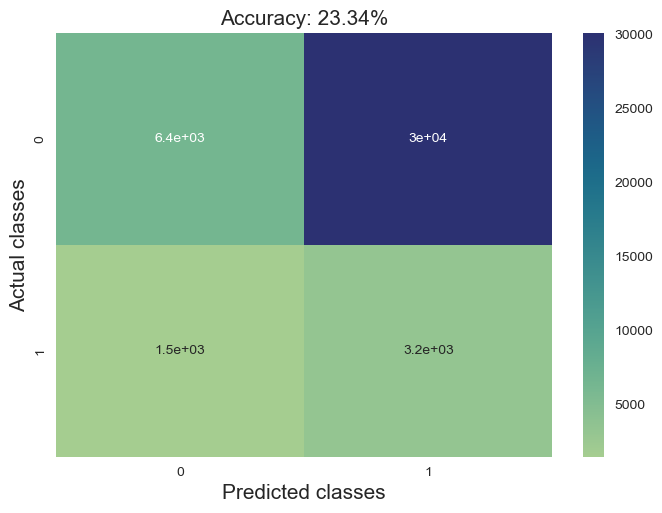


 Classification report:

               precision    recall  f1-score   support

           0       0.82      0.18      0.29     36537
           1       0.10      0.69      0.17      4639

    accuracy                           0.23     41176
   macro avg       0.46      0.43      0.23     41176
weighted avg       0.73      0.23      0.28     41176



In [112]:
plot_confusion_matrix(y, y_pred_GD, accuracy_GD)

### Stochastic Gradient Descent:

In [113]:
def StochasticGradientDescent( in_X, in_y, in_theta, alpha=0.1, num_iter=50, batch_size=8 ):
    X = in_X.copy()
    y = in_y.copy()
    theta = in_theta.copy()
    X_len = X.shape[0]
    idx = np.arange(X_len)
    num_iter = math.ceil( num_iter/batch_size ) # reduction in respect to batching
    
    for _ in range(num_iter):
        idx = np.random.permutation(idx)
        X, y = X[idx], y[idx]
        for start in range(0, X_len, batch_size):
            stop = start + batch_size
            J, dJ0, dJ = CostFunction( X[start:stop,:], y[start:stop], theta )
            theta[0] = theta[0] - alpha * dJ0.sum()
            theta[1:] = theta[1:] - alpha * dJ
    
    return theta, J

In [114]:
time_SGD = %timeit -r 3 -n 5 -o StochasticGradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER, BATCH_SIZE)
print( 'Runned 3x5 executions.' )

3.53 s ± 82.8 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
Runned 3x5 executions.


In [115]:
theta_opt_SGD, J_opt_SGD = StochasticGradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER, BATCH_SIZE)

In [116]:
print( 'Minimum found by algorithm:', J_opt_SGD )

Minimum found by algorithm: 0.31442236271130897


In [117]:
y_pred_SGD = predict(X_norm, theta_opt_SGD)

In [118]:
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Accuracy: {accuracy_SGD:.6f}' )

Accuracy: 0.902905


Confusion matrix:


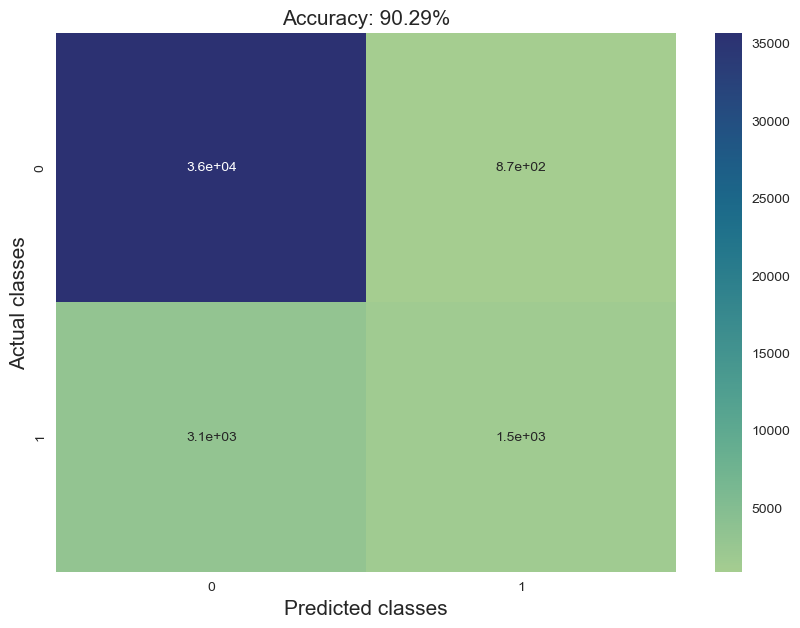


 Classification report:

               precision    recall  f1-score   support

           0       0.92      0.98      0.95     36537
           1       0.63      0.33      0.43      4639

    accuracy                           0.90     41176
   macro avg       0.78      0.65      0.69     41176
weighted avg       0.89      0.90      0.89     41176



In [119]:
plot_confusion_matrix(y, y_pred_SGD, accuracy_SGD)

### Undersampling:

In [120]:
NUM_SAMPLES = int( m*SAMPLING_FRACTION )
idx_sampled = np.random.choice( m, size=NUM_SAMPLES, replace=False )

# check that each item occurs only once
print( "Are the samples in the new set repeated:", ( np.bincount(idx_sampled.ravel()) == 1 ).all() )

Are the samples in the new set repeated: False


In [121]:
X_sampled, y_sampled = X_norm[idx_sampled,:], y[idx_sampled]

In [122]:
time_Sampl = %timeit -r 3 -n 5 -o GradientDescent(X_sampled, y_sampled, theta_0, ALPHA, NUM_ITER)
print( 'Runned 3x5 executions.' )

3.41 s ± 4.58 ms per loop (mean ± std. dev. of 3 runs, 5 loops each)
Runned 3x5 executions.


In [123]:
theta_opt_Sampl, J_opt_Sampl = GradientDescent(X_sampled, y_sampled, theta_0, ALPHA, NUM_ITER)

In [124]:
print( 'Minimum found by algorithm:', J_opt_Sampl )

Minimum found by algorithm: 3.5742954841956154


In [125]:
y_pred_Sampl = predict(X_norm, theta_opt_Sampl)

In [126]:
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Accuracy: {accuracy_Sampl:.6f}' )

Accuracy: 0.233631


Confusion matrix:


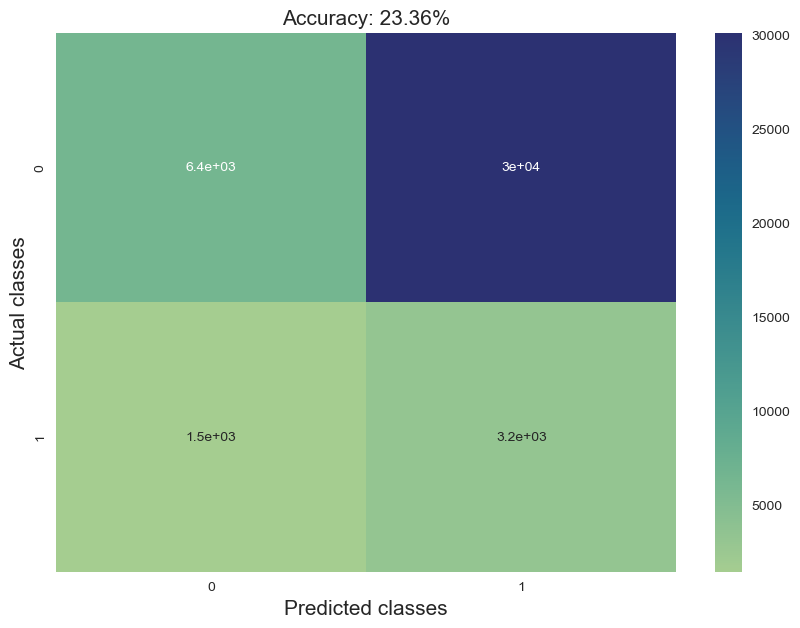


 Classification report:

               precision    recall  f1-score   support

           0       0.82      0.18      0.29     36537
           1       0.10      0.69      0.17      4639

    accuracy                           0.23     41176
   macro avg       0.46      0.43      0.23     41176
weighted avg       0.73      0.23      0.28     41176



In [127]:
plot_confusion_matrix(y, y_pred_Sampl, accuracy_Sampl)

In [128]:
methods_names = ['GD', 'SGD', 'Sampled']

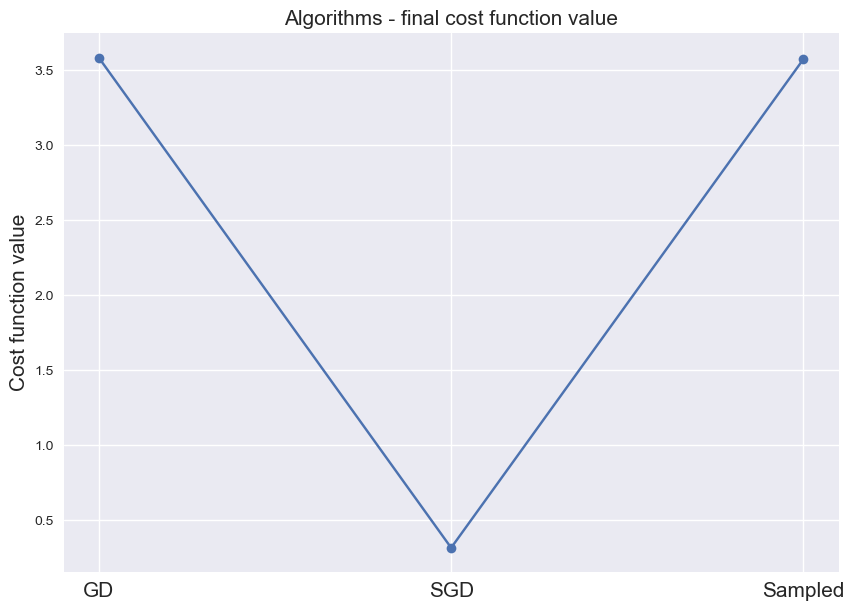

In [129]:
plt.plot([J_opt_GD, J_opt_SGD, J_opt_Sampl], '-o')
plt.title('Algorithms - final cost function value', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Cost function value', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [130]:
print(f'Accuracy of SGD to GD one: {accuracy_SGD/accuracy_GD:.5f}, to Sampled GD one: {accuracy_SGD/accuracy_Sampl:.5f}.')

Accuracy of SGD to GD one: 3.86828, to Sampled GD one: 3.86466.


In [131]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

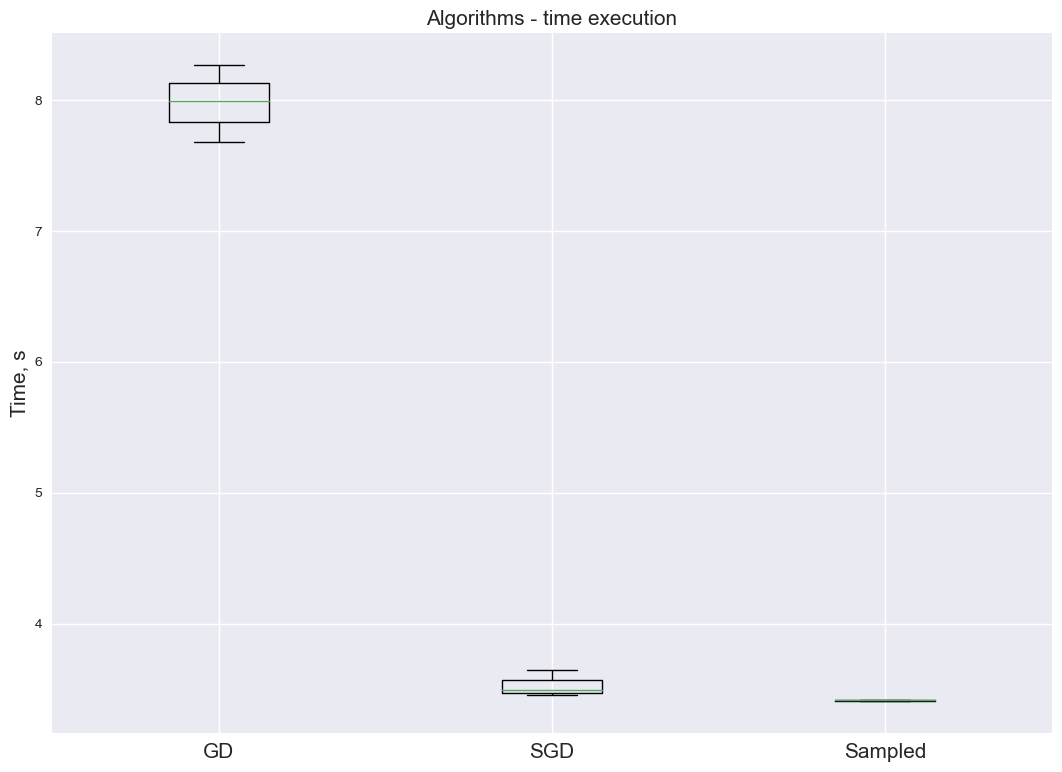

In [132]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorithms - time execution', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Time, s', size=15)
plt.show()

In [133]:
print(f'Time performance of SGD to GD: {time_GD.best/time_SGD.best:.2f}:1, to Sampled GD {time_Sampl.best/time_SGD.best:.2f}:1.')
print(f'Time performance of Sampled GD to GD: {time_GD.best/time_Sampl.best:.2f}:1.')

Time performance of SGD to GD: 2.22:1, to Sampled GD 0.99:1.
Time performance of Sampled GD to GD: 2.25:1.


### Tests for hypotheses $\theta_{1}$ i $\theta_{2}$:

In [ ]:
theta_1 = np.random.rand(n+1)
print('Hypothesis:\n', theta_1[:])

In [ ]:
time_GD = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
theta_opt_GD, J_opt_GD = GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
y_pred_GD = predict(X_norm, theta_opt_GD)
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Accuracy: {accuracy_GD:.6f}' )

In [ ]:
time_SGD = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
theta_opt_SGD, J_opt_SGD = StochasticGradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER, BATCH_SIZE)

In [ ]:
y_pred_SGD = predict(X_norm, theta_opt_SGD)
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Accuracy: {accuracy_SGD:.6f}' )

In [ ]:
time_Sampl = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
theta_opt_Sampl, J_opt_Sampl = GradientDescent(X_sampled, y_sampled, theta_1, ALPHA, NUM_ITER)

In [ ]:
y_pred_Sampl = predict(X_norm, theta_opt_Sampl)
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Accuracy: {accuracy_Sampl:.6f}' )

In [ ]:
plt.plot([J_opt_GD, J_opt_SGD, J_opt_Sampl], '-o')
plt.title('Algorithms - final cost function value', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Cost function value', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [ ]:
print(f'Accuracy of SGD to GD one: {accuracy_SGD/accuracy_GD:.5f}, to Sampled GD one: {accuracy_SGD/accuracy_Sampl:.5f}.')

In [ ]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

In [ ]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorithms - time execution', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Time, s', size=15)
plt.show()

In [ ]:
print(f'Time performance of SGD to GD: {time_GD.best/time_SGD.best:.2f}:1, to Sampled GD {time_Sampl.best/time_SGD.best:.2f}:1.')
print(f'Time performance of Sampled GD to GD: {time_GD.best/time_Sampl.best:.2f}:1.')

In [ ]:
theta_2 = np.random.rand(n+1)
print('Hypothesis:\n', theta_2[:])

In [ ]:
time_GD = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
theta_opt_GD, J_opt_GD = GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
y_pred_GD = predict(X_norm, theta_opt_GD)
accuracy_GD = get_accuracy(y, y_pred_GD)
print( f'Accuracy: {accuracy_GD:.6f}' )

In [ ]:
time_SGD = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
theta_opt_SGD, J_opt_SGD = StochasticGradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER, BATCH_SIZE)

In [ ]:
y_pred_SGD = predict(X_norm, theta_opt_SGD)
accuracy_SGD = get_accuracy(y, y_pred_SGD)
print( f'Accuracy: {accuracy_SGD:.6f}' )

In [ ]:
time_Sampl = %timeit -r 3 -n 5 -o GradientDescent(X_norm, y, theta_1, ALPHA, NUM_ITER)

In [ ]:
theta_opt_Sampl, J_opt_Sampl = GradientDescent(X_sampled, y_sampled, theta_1, ALPHA, NUM_ITER)

In [ ]:
y_pred_Sampl = predict(X_norm, theta_opt_Sampl)
accuracy_Sampl = get_accuracy(y, y_pred_Sampl)
print( f'Accuracy: {accuracy_Sampl:.6f}' )

In [ ]:
plt.plot([J_opt_GD, J_opt_SGD, J_opt_Sampl], '-o')
plt.title('Algorithms - final cost function value', size=15)
plt.xticks([0, 1, 2], methods_names, size=15)
plt.ylabel('Cost function value', size=15)
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

In [ ]:
print(f'Accuracy of SGD to GD one: {accuracy_SGD/accuracy_GD:.5f}, to Sampled GD one: {accuracy_SGD/accuracy_Sampl:.5f}.')

In [ ]:
timings_GD = time_GD.timings[:]
timings_SGD = time_SGD.timings[:]
timings_Sampl = time_Sampl.timings[:]
timings = [timings_GD, timings_SGD, timings_Sampl]

In [ ]:
fig = plt.figure(figsize = (HEIGHT, WEIGHT))
ax = fig.add_axes([0, 0, 1, 1])
bp = ax.boxplot(timings)
ax.set_title('Algorithms - time execution', size=15)
ax.set_xticks([1, 2, 3], methods_names, size=15)
ax.set_ylabel('Time, s', size=15)
plt.show()

In [ ]:
print(f'Time performance of SGD to GD: {time_GD.best/time_SGD.best:.2f}:1, to Sampled GD {time_Sampl.best/time_SGD.best:.2f}:1.')
print(f'Time performance of Sampled GD to GD: {time_GD.best/time_Sampl.best:.2f}:1.')

### Analysis of performed simulations:

In [ ]:
def AnalyzeGradientDescent( X, y, in_theta, alpha=0.1, num_iter=50 ):
    theta = in_theta.copy()
    
    J_list = []
    theta_list = []
    
    for _ in range(num_iter):
        J, dJ0, dJ = CostFunction(X, y, theta)
        theta[0] = theta[0] - alpha * dJ0.sum()
        theta[1:] = theta[1:] - alpha * dJ
        J_list.append(J)
        theta_list.append(theta)
        
    return np.array(theta_list), np.array(J_list)

In [ ]:
def AnalyzeStochasticGradientDescent( in_X, in_y, in_theta, alpha=0.1, num_iter=50, batch_size=8 ):
    X = in_X.copy()
    y = in_y.copy()
    theta = in_theta.copy()
    X_len = X.shape[0]
    idx = np.arange(X_len)
    epochs = math.ceil( num_iter/ (X_len/batch_size) )
    
    J_list = []
    theta_list = []
    
    for i in range(epochs):
        idx = np.random.permutation(idx)
        X, y = X[idx], y[idx]
        for start in range(0, X_len, batch_size):
            stop = start + batch_size
            J, dJ0, dJ = CostFunction( X[start:stop,:], y[start:stop], theta )
            theta[0] = theta[0] - alpha * dJ0.sum()
            theta[1:] = theta[1:] - alpha * dJ
            J_list.append(J)
            theta_list.append(theta)
            
            if (i*(X_len/batch_size) + start/batch_size) > num_iter:
                break
        
    return np.array(theta_list), np.array(J_list)

In [ ]:
theta_opt_GD_list, J_opt_GD_list = AnalyzeGradientDescent(X_norm, y, theta_0, ALPHA, NUM_ITER)

In [ ]:
theta_opt_SGD_list, J_opt_SGD_list = AnalyzeStochasticGradientDescent(
                            X_norm, y, theta_0, ALPHA, NUM_ITER, BATCH_SIZE
                        )

In [ ]:
theta_opt_Sampl_list, J_opt_Sampl_list = AnalyzeGradientDescent(X_sampled, y_sampled, theta_0, ALPHA, NUM_ITER)

In [ ]:
iters_range = range( len(J_opt_GD_list) )
plt.plot( range( len(J_opt_SGD_list) ), J_opt_SGD_list, label='SGD' )
plt.plot( iters_range, J_opt_GD_list, label='GD' )
plt.plot( iters_range, J_opt_Sampl_list, label='Sampled' )
plt.xlabel('Number of iterations', size=15)
plt.ylabel('Cost function value', size=15)
plt.title('Learning process', size=15)
plt.legend( loc='best' )
plt.rcParams["figure.figsize"] = HEIGHT, WEIGHT
plt.show()

## Conclusions:
* Metoda SGD okazała się być metodą mogącą być porównywalną (prypadek hipotezy $\theta_{2}$) lub kilkukrotnie, nawet ponad 10-krotnie, szybszą od GD i Sampled GD.
* Dla wszystkich prypadków metoda SGD zwracała mniejsze wartości (minima lokalne), względem GD i Sampled GD.
* Generalnie metoda Sampled GD okazała się być metodą szybszą od metody GD- poza prypadkiem hipotezy $\theta_{2}$.
* Metody uzyskiwały podobną dokładność we wszystkich przypadkach - zależnie od hipotezy - z maksymalnymi różnicami dokładności na poziomie do 1%.
* Zbiór danych nie został dobrze przygotowany przez co trudne było uzyskanie dokładności na poziomie ok. 90%.
* Proces szukania rozwiązania u metody SGD charakteryzuje się zmiennością zwracanych rozwiązań w porównaniu z pozostałymi metodami.

## References:

[1] A. Ng, "CS229. Lecture notes. Supervised learning", 2012, [na:] https://web.archive.org/web/20180618211933/http://cs229.stanford.edu/notes/cs229-notes1.pdf, [dostęp:] 21.01.2023.  
[2] A. Pant, "Introduction to Logistic Regression", 2019, [na:] https://towardsdatascience.com/introduction-to-logistic-regression-66248243c148, [dostęp:] 24.01.2023.  
[3] https://archive.ics.uci.edu/ml/datasets/spambase, [dostęp:] 24.01.2023.  
[4] https://stackoverflow.com/a/29863846, [dostęp:] 21.01.2023.  
[5] https://realpython.com/gradient-descent-algorithm-python/, [dostęp:] 21.01.2023.  